In [1]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time
import pandas as pd
import seaborn as sns

import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [2]:
#loading population data
population_key= pd.read_csv("sample_key.txt", sep='\t', header=None)
#population_key.set_index()

#changing the first row to headers
headers = population_key.iloc[0]
population_key_new  = pd.DataFrame(population_key.values[1:], columns=headers) 
print(population_key_new.head(5))

# Regroup S GT and W GT together as SW GT
population_key_new2=population_key_new
population_key_new2.loc[population_key_new2['CLUSTER'] == 'West_Grande_Terre', 'CLUSTER'] = 'SW_Grande_Terre'
population_key_new2.loc[population_key_new2['CLUSTER'] == 'South_Grande_Terre', 'CLUSTER'] = 'SW_Grande_Terre'
print(population_key_new2.head(5))



0 FID   IID            CLUSTER
0   1   ACP             Picard
1   2   AGO             Picard
2   3   AHC             Picard
3   4  AM01  West_Grande_Terre
4   5  AM07  West_Grande_Terre
0 FID   IID          CLUSTER
0   1   ACP           Picard
1   2   AGO           Picard
2   3   AHC           Picard
3   4  AM01  SW_Grande_Terre
4   5  AM07  SW_Grande_Terre


In [3]:
clusters_to_check=('SW_Grande_Terre','East_Grande_Terre','East_Malabar','West_Malabar')
#print(len(clusters_to_check))
#print(clusters_to_check[0])

#deneme
#Pop1=population_key_new.loc[population_key_new['CLUSTER'] == 'Picard', 'FID']

#print(Pop1)

In [4]:
#generate a dictionary that contains clusters to check and IDs in it
#df is the dataframe version and np is numpy array, will continue with np

struct_np=dict() #initiate an empty dictionary

for i in range(0,len(clusters_to_check)):
    struct_np[clusters_to_check[i]] = np.array((population_key_new2.loc[population_key_new2['CLUSTER'] == clusters_to_check[i], 'FID']))


#print(struct_np['South_Grande_Terre'])
print(struct_np.keys())
print(struct_np)

dict_keys(['SW_Grande_Terre', 'East_Grande_Terre', 'East_Malabar', 'West_Malabar'])
{'SW_Grande_Terre': array(['4', '5', '6', '7', '10', '11', '12', '13', '14', '15', '16', '46',
       '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', '128', '129', '130', '133'], dtype=object), 'East_Grande_Terre': array(['23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '70', '71', '72', '73', '74', '131',
       '132', '134', '135'], dtype=object), 'East_Malabar': array(['102', '103', '104', '105', '106', '107', '108', '109', '110',
       '111', '112', '113', '114', '115', '116', '117'], dtype=object), 'West_Malabar': array(['136', '137', '138', '139', '140', '141', '142'], dtype=object)}


In [5]:
#generating combinations of the clusters to check so that the histograms etc. will be as Cluster1 vs Cluster2
from itertools import combinations

combs= list(combinations(struct_np.keys(), 2))

print(len(combs))
print(combs)

6
[('SW_Grande_Terre', 'East_Grande_Terre'), ('SW_Grande_Terre', 'East_Malabar'), ('SW_Grande_Terre', 'West_Malabar'), ('East_Grande_Terre', 'East_Malabar'), ('East_Grande_Terre', 'West_Malabar'), ('East_Malabar', 'West_Malabar')]


In [6]:
#loading relatedness data and correcting the idx so that there wont be 0 and it will match the individual samples' id
relatedness= pd.read_csv("deneme_rm1_20_m05.txt", sep='\t') # load relatedness data
relatedness['a']=relatedness['a']+1 # correct the IDs so that they will match the ones in the dictionaries as combinations
relatedness['b']=relatedness['b']+1 # same as above, this time for the b column.
print(relatedness.head(2))

   a  b  ida  idb   nSites        J9        J8        J7        J6        J5  \
0  1  2  ACP  AGO  4398322  0.449125  0.281608  0.057019  0.055365  0.013619   
1  1  3  ACP  AHC  4329358  0.422116  0.324969  0.023196  0.024080  0.062928   

   ...         loglh  nIter  bestoptimll  coverage  \
0  ... -5.831279e+06    178         -1.0  0.593536   
1  ... -5.641914e+06    178         -1.0  0.584229   

                                               2dsfs        R0        R1  \
0  4.297776e-01,1.356807e-01,2.965957e-02,1.29289...  0.507865  0.308364   
1  4.353710e-01,1.364934e-01,2.287467e-02,1.34146...  0.461462  0.286587   

       KING  2dsfs_loglike  2dsfsf_niter  
0 -0.003322  -6.275533e+06            30  
1  0.015330  -6.076937e+06            30  

[2 rows x 35 columns]


In [7]:
#in a for loop we will search through the relatedness data for the Cluster1vsCluster2 Id's and then take the rab value
#from column14

pair_ids=np.array(relatedness.iloc[:,0:2])

indices_np=dict()
values_np=dict()
for i in range(0,len(combs)):
    indices_np[combs[i][0]+'_vs_'+combs[i][1]]=[]
    values_np[combs[i][0]+'_vs_'+combs[i][1]]=[]
    for element in itertools.product(struct_np[combs[i][0]],struct_np[combs[i][1]]):

        element_lst=list(element)
        element_srt=np.array(element_lst,dtype='int16')
        element_srt.sort()
        
        #print('list:'+str(element_lst)+'array:'+str(element_srt))
    
        #if int(element[0]) > int(element[1]):
        #   # print('degistirelim:')
        #    element_srt=sorted(element)
        #else:
        #  #  print('bununla devam:')
        #    element_srt=element
            
        #print(element)
        indices_np[combs[i][0]+'_vs_'+combs[i][1]].append(element_srt) # element is the pair of IDa vs IDb such as 1x143
        
        temp_idx=np.where((pair_ids[:,0] == int(element_srt[0])) & (pair_ids[:,1] == int(element_srt[1])))        
        #orjinali values_np[combs[i][0]+'_vs_'+combs[i][1]].append(relatedness.iloc[temp_idx[0],14].to_numpy()) # 14 is to take out rab data
        values_np[combs[i][0]+'_vs_'+combs[i][1]].append(relatedness.iloc[temp_idx[0],14].to_numpy(dtype='float16').round(2))
        del temp_idx
                
print(indices_np['SW_Grande_Terre_vs_East_Grande_Terre'][-5])
print(values_np['SW_Grande_Terre_vs_East_Grande_Terre'][-5])

#print(values_np['East_Grande_Terre_vs_East_Malabar'][:])

#plt.hist(values_np['East_Grande_Terre_vs_East_Malabar'])

#deneme=np.asarray(values_np['SW_Grande_Terre_vs_East_Grande_Terre'])

#print(deneme)
#print(indices_np['East_Malabar_vs_West_Malabar'])




[ 74 133]
[0.01]


In [8]:
print(values_np.keys())
#print(np.asarray(values_np['East_Malabar_vs_West_Malabar']))



dict_keys(['SW_Grande_Terre_vs_East_Grande_Terre', 'SW_Grande_Terre_vs_East_Malabar', 'SW_Grande_Terre_vs_West_Malabar', 'East_Grande_Terre_vs_East_Malabar', 'East_Grande_Terre_vs_West_Malabar', 'East_Malabar_vs_West_Malabar'])


In [ ]:
# single module for histograms.

temp_data=np.asarray(values_np['SW_Grande_Terre_vs_East_Grande_Terre'])
temp_data_pd=pd.DataFrame(temp_data,columns=['relatedness'],dtype='float16')

#temp_data_pd['relatedness']=temp_data_pd['relatedness'].replace(0,np.nan)
        
fig, axs = plt.subplots(2, 2,figsize=(20, 12))
ax1 = axs[0,0]
sns.histplot(ax=ax1,data=temp_data_pd, x='relatedness',stat='probability').set(title='SW_Grande_Terre_vs_East_Grande_Terre')
ax1.set_xlim([0.00, 1])
ax1.set_ylim([0, 1])
#ax1.axvline(x = 0.05, color = 'r', label = 'threshold',linestyle='--')
ax1.text(0.55,0.85,'total n: '+str(temp_data_pd['relatedness'].count()))



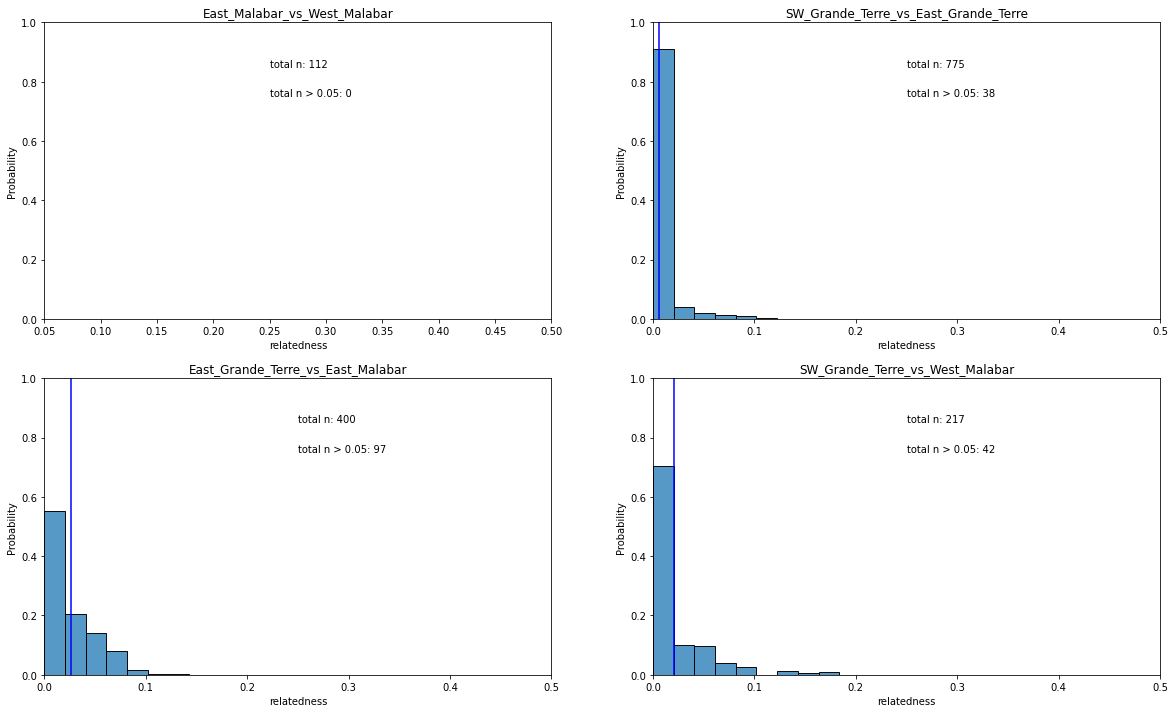

In [9]:
# subplots for histograms.
fig, axs = plt.subplots(2, 2,figsize=(20, 12))
bin_edges=np.linspace(0.0,1,50)
threshold=0.00
# below is for within islands

#E M vs W M
temp_data=np.asarray(values_np['East_Malabar_vs_West_Malabar'])
temp_data_pd=pd.DataFrame(temp_data,columns=['relatedness'],dtype='float16')
temp_mean=temp_data_pd['relatedness'].mean()
temp_data_pd.loc[temp_data_pd['relatedness']<threshold]=np.nan
#temp_data_pd['relatedness']=temp_data_pd['relatedness'].replace(0,np.nan)    
ax1 = axs[0,0]
sns.histplot(ax=ax1,data=temp_data_pd, x='relatedness',bins=bin_edges,stat='probability').set(title='East_Malabar_vs_West_Malabar')
ax1.set_xlim([0.05, 0.5])
ax1.set_ylim([0, 1])
#ax1.axvline(x = 0.05, color = 'r', label = 'threshold',linestyle='--')
ax1.axvline(x = temp_mean, color = 'b', label = 'threshold',linestyle='-')
ax1.text(0.25,0.85,'total n: '+str(temp_data_pd['relatedness'].count()))
ax1.text(0.25,0.75,'total n > 0.05: '+str(temp_data_pd.loc[temp_data_pd['relatedness']>=0.05].count()[0]))

del temp_data_pd
del temp_data
del temp_mean



#E GT vs S+W GT
temp_data=np.asarray(values_np['SW_Grande_Terre_vs_East_Grande_Terre'])
temp_data_pd=pd.DataFrame(temp_data,columns=['relatedness'],dtype='float16')
temp_mean=temp_data_pd['relatedness'].mean()
temp_data_pd.loc[temp_data_pd['relatedness']<threshold]=np.nan
#temp_data_pd['relatedness']=temp_data_pd['relatedness'].replace(0,np.nan)      
ax2 = axs[0,1]
sns.histplot(ax=ax2,data=temp_data_pd, x='relatedness',bins=bin_edges,stat='probability').set(title='SW_Grande_Terre_vs_East_Grande_Terre')
ax2.set_xlim([0.00, 0.5])
ax2.set_ylim([0, 1])
#ax2.axvline(x = 0.05, color = 'r', label = 'threshold',linestyle='--')
ax2.axvline(x = temp_mean, color = 'b', label = 'threshold',linestyle='-')
ax2.text(0.25,0.85,'total n: '+str(temp_data_pd['relatedness'].count()))
ax2.text(0.25,0.75,'total n > 0.05: '+str(temp_data_pd.loc[temp_data_pd['relatedness']>=0.05].count()[0]))


del temp_data_pd
del temp_data
del temp_mean


            #
# below is for between islands
           #
           
#E M vs E GT
temp_data=np.asarray(values_np['East_Grande_Terre_vs_East_Malabar'])
temp_data_pd=pd.DataFrame(temp_data,columns=['relatedness'],dtype='float16')
temp_mean=temp_data_pd['relatedness'].mean()
temp_data_pd.loc[temp_data_pd['relatedness']<threshold]=np.nan
#temp_data_pd['relatedness']=temp_data_pd['relatedness'].replace(0,np.nan)      
ax3 = axs[1,0]
sns.histplot(ax=ax3,data=temp_data_pd, x='relatedness',bins=bin_edges,stat='probability').set(title='East_Grande_Terre_vs_East_Malabar')
ax3.set_xlim([0.00, 0.5])
ax3.set_ylim([0, 1])
#ax3.axvline(x = 0.05, color = 'r', label = 'threshold',linestyle='--')
ax3.axvline(x = temp_mean, color = 'b', label = 'threshold',linestyle='-')
ax3.text(0.25,0.85,'total n: '+str(temp_data_pd['relatedness'].count()))
ax3.text(0.25,0.75,'total n > 0.05: '+str(temp_data_pd.loc[temp_data_pd['relatedness']>=0.05].count()[0]))


del temp_data_pd
del temp_data
del temp_mean

           
#W M vs S+W GT
temp_data=np.asarray(values_np['SW_Grande_Terre_vs_West_Malabar'])
temp_data_pd=pd.DataFrame(temp_data,columns=['relatedness'],dtype='float16')
temp_mean=temp_data_pd['relatedness'].mean()
temp_data_pd.loc[temp_data_pd['relatedness']<threshold]=np.nan
#temp_data_pd['relatedness']=temp_data_pd['relatedness'].replace(0,np.nan)      
ax4 = axs[1,1]
sns.histplot(ax=ax4,data=temp_data_pd, x='relatedness',bins=bin_edges,stat='probability').set(title='SW_Grande_Terre_vs_West_Malabar')
ax4.set_xlim([0.00, 0.5])
ax4.set_ylim([0, 1])
#ax4.axvline(x = 0.05, color = 'r', label = 'threshold',linestyle='--')
ax4.axvline(x = temp_mean, color = 'b', label = 'threshold',linestyle='-')
ax4.text(0.25,0.85,'total n: '+str(temp_data_pd['relatedness'].count()))
ax4.text(0.25,0.75,'total n > 0.05: '+str(temp_data_pd.loc[temp_data_pd['relatedness']>=0.05].count()[0]))


del temp_data_pd
del temp_data
del temp_mean



#plt.savefig('Relatedness_4plots_xlim0.png',format='png',dpi=100,transparent = False,facecolor='white')




In [ ]:
# get the cluster names
population_key_df= pd.DataFrame(population_key.values[1:], columns=headers) 

print(population_key_new['CLUSTER'].unique())

print(population_key_df.head(5))


In [ ]:
#initiate a relatedness matrix
relatedness_matrix=np.zeros((cluster_names.shape[0],cluster_names.shape[0]))
deneme=[]

In [ ]:
print(relatedness.iloc[1,14])
print(relatedness.iloc[1,0])
print(relatedness.iloc[1,1])

%print( relatedness_matrix[int(relatedness.iloc[1,0]),int(relatedness.iloc[1,1])])


In [ ]:

relatedness_matrix=np.zeros((cluster_names.shape[0],cluster_names.shape[0])) # generate an empty matrix with zeros

#we fill the relatedness matrix with ida vs idb and the value in rab column.
for i in range(1,relatedness.shape[0]):
    relatedness_matrix[int(relatedness.iloc[i,0]),int(relatedness.iloc[i,1])]=relatedness.iloc[i,14] # 14 stands for rab column
    relatedness_matrix[int(relatedness.iloc[i,1]),int(relatedness.iloc[i,0])]=relatedness.iloc[i,14] # 14 stands for rab column


    

In [ ]:
print(relatedness_matrix[2,4])
sns.heatmap(relatedness_matrix)

In [ ]:
cluster_names_list=population_key_new['CLUSTER'].tolist()
#cluster_names_list_srt=sorted(cluster_names_list)

cluster_names_list_srt_indices=np.argsort(cluster_names_list)


print(cluster_names_list_srt_indices[0:5])
#print(cluster_names_list_srt[0:5])





In [ ]:
#trying to reorder the matrix according to the new key
#new_order = [0, 3, 1, 4, 2, 5]    # maps previous index to new index
relatedness_matrix_sorted = [[relatedness_matrix[i][j] for j in cluster_names_list_srt_indices] for i in cluster_names_list_srt_indices]

In [ ]:
sns.heatmap(relatedness_matrix_sorted)